# Regularization Techniques: Lasso and Ridge Regression

# Introduction and Dataset

## Background

This tutorial will explore Lasso and Ridge regression methods to model different response variables that are commonly modeled in forestry. These include quadratic mean diameter (QMD), aboveground biomass (AGB), and basal area (BA). The tutorial will employ a suite of input features (i.e., predictor variables) used to estimate the response variables. 

## Tutorial goals

**Goal 1: Develope ridge and lasso regression models for QMD, AGB, and BA using LiDAR and multispectral predictor variables**

**Goal 2: Compare ridge and lasso models for each response variable and choose the best model for each**

**Goal 3: Apply the best performing model for each response variable across the entire PRF**

-----

## Data

Please refer to the README on the main GitHub page for a detailed description of each file.


## Packages

- GeoPandas
- rioxarray
- spyndex

# Install and load packages

**Uncomment the cell below to install required packages**

In [1]:
# !pip install pandas==2.2.2
# !pip install geopandas==1.0.1
# !pip install matplotlib==3.10.1
# !pip install rioxarray==0.19.0
# !pip install spyndex==0.5.0
# !pip install pyarrow==19.0.0

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rio
import spyndex
from spyndex import indices
from math import sqrt, pi
import matplotlib.pyplot as plt
from rasterio.plot import show
from matplotlib import pyplot as plt

# Download data

In [3]:
# Download the data if it does not yet exist
if not os.path.exists("data"):
  !gdown 1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2
  !unzip prf_data.zip -d data/
  os.remove("prf_data.zip")
else:
  print("Data has already been downloaded.")

os.listdir("data")

Data has already been downloaded.


['als_metrics.tif',
 'boundary.gpkg',
 'forest_point_cloud.las',
 'forest_point_cloud_footprint.gpkg',
 'original',
 'petawawa_s2_2018.tif',
 'petawawa_s2_2024.tif',
 'plots.gpkg',
 'trees.csv',
 'water.gpkg']

# Preprocessing

Before we can begin with ridge and lasso regression, we must first preprocess the data so it is analysis ready. The following code blocks will prepare both the response variables (QMD, AGB, BA) in addition to predictor variables (99th height percentile and spectral indices).

In [4]:

trees_df = gpd.read_file(r'data/trees.csv')

plots_gdf = gpd.read_file(r'data/plots.gpkg').rename(columns={"Plot": "PlotName"})

print(trees_df.head())

  PlotName TreeID      species Origin Status   DBH CrownClass DecayClass  \
0   PRF001   24.0  White pine       P      D  10.1                   1.0   
1   PRF001   46.0  White pine       P      D   9.9                   2.0   
2   PRF001   20.0    Red pine       N      L  67.5          D              
3   PRF001   50.0    Red pine       N      L  57.9          D              
4   PRF001   10.0  White pine       N      L  55.9          D              

         height          baha codom          mvol          tvol       biomass  \
0  11.552521235  0.1281898464     N           0.0  0.7087347141   393.3964002   
1  11.422529245  0.1231632864     N           0.0  0.6732544319  375.30537899   
2          33.9      5.725566     Y  77.327438489  79.482658012   39691.63995   
3  32.528850963  4.2127725024     Y  56.444280856  58.117291913  28251.255888   
4          33.0  3.9267612384     Y  48.008649036  49.833742798  24501.838779   

    size  
0  Poles  
1  Poles  
2  Large  
3  Large  
4

In [5]:
# Ensure multiple columns in trees df are numeric
cols_to_convert = ['biomass', 'height', 'baha', 'DBH']
for col in cols_to_convert:
    trees_df[col] = pd.to_numeric(trees_df[col])

trees_df

,PlotName,TreeID,species,Origin,Status,DBH,CrownClass,DecayClass,height,baha,codom,mvol,tvol,biomass,size
0,PRF001,24.0,White pine,P,D,10.1,,1.0,11.552521,0.128190,N,0.0,0.7087347141,393.396400,Poles
1,PRF001,46.0,White pine,P,D,9.9,,2.0,11.422529,0.123163,N,0.0,0.6732544319,375.305379,Poles
2,PRF001,20.0,Red pine,N,L,67.5,D,,33.900000,5.725566,Y,77.327438489,79.482658012,39691.639950,Large
3,PRF001,50.0,Red pine,N,L,57.9,D,,32.528851,4.212773,Y,56.444280856,58.117291913,28251.255888,Large
4,PRF001,10.0,White pine,N,L,55.9,D,,33.000000,3.926761,Y,48.008649036,49.833742798,24501.838779,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12585,PRF334,,Sugar Maple,N,L,3.7,,,8.893640,0.215043,N,0.0,0.8585643577,851.191939,Under
12586,PRF334,,Sugar Maple,N,L,3.3,,,8.500000,0.171060,N,0.0,0.6538680809,659.084439,Under
12587,PRF334,,Sugar Maple,N,L,3.2,,,8.395967,0.160850,N,0.0,0.607492501,615.333049,Under
12588,PRF334,,Sugar Maple,N,L,3.0,,,7.400000,0.141372,N,0.0,0.4696555303,521.064025,Under


In [6]:
# Check the range of various tree attributes
trees_df.describe()

,DBH,height,baha,biomass
count,12590.000000,12590.000000,12590.000000,12342.000000
mean,17.622415,15.883219,0.602011,3286.085532
std,11.559345,6.713323,0.895101,6305.457552
min,2.500000,1.301584,0.070686,138.409692
25%,10.600000,11.531384,0.174975,634.448847
50%,14.500000,14.907205,0.309749,1266.913205
75%,21.100000,19.398785,0.623451,2800.442589
max,97.500000,50.300000,11.945934,89100.864298


## Response Variables

### Quadratic Mean Diameter

Quadratic Mean Diameter (QMD) is a common stand level attribute that is modeled in forestry. QMD is often prefered over the arithmetic mean in forestry because it gives greater weight to larger trees. This is relevant for several reasons, primarily though because the wood from larger trees is more valuable.

QMD also is relevant for understanding forest ecology among other applications.

              qmd
count  249.000000
mean    22.515733
std      7.292152
min      9.487689
25%     17.508306
50%     20.996809
75%     25.918597
max     58.166457


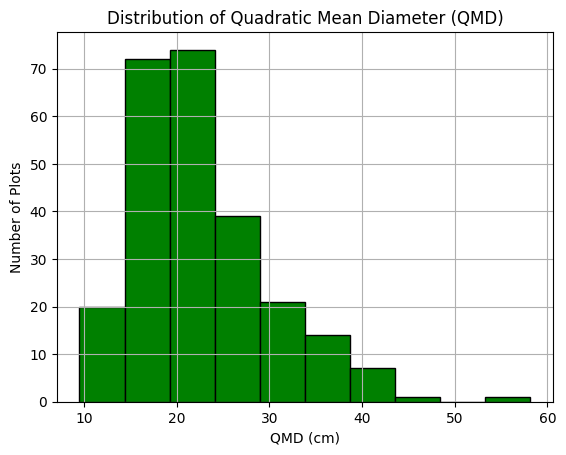

In [7]:
# Calculate the Quadratic Mean Diameter (QMD)
qmd_df = (
    trees_df
    .groupby('PlotName')
    .agg(
        n_trees=('DBH', 'count'),
        sum_squares=('DBH', lambda x: (x**2).sum())
    )
    .assign(qmd=lambda df: (df['sum_squares'] / df['n_trees']).apply(sqrt))
    .reset_index()[['PlotName', 'qmd']]
)

print(qmd_df.describe())

# Join with plots GeoDataFrame
plots_gdf = plots_gdf.merge(qmd_df, on='PlotName', how='left')

ax = plots_gdf['qmd'].hist(edgecolor='black', color='green')
ax.set_xlabel('QMD (cm)')
ax.set_ylabel('Number of Plots')
ax.set_title('Distribution of Quadratic Mean Diameter (QMD)')
plt.show()

### Aboveground Biomass (AGB)

Forest aboveground biomass (AGB) is another very common stand attribute to model. Biomass is defined as the living organic materials comprising trees including wood, bark, branches, foliage, etc. AGB is modeled for many different reasons. One relevant application of AGB modelling is for forest carbon projects, since forest aboveground carbon is typically estimated to be ~50% of AGB.

We can calculate plot-level AGB by summing the AGB of all trees in a plot, and then dividing that by the plot area. This is performed in the code below.

Area of each plot in hectares: 0.0625 ha
       biomass_Mg_total  biomass_Mg_ha
count        249.000000     249.000000
mean          10.179937     162.878987
std            5.571596      89.145529
min            0.146435       2.342960
25%            6.375452     102.007230
50%            9.263491     148.215860
75%           12.238090     195.809442
max           35.127161     562.034569


Text(0.5, 1.0, 'Distribution of Aboveground Biomass')

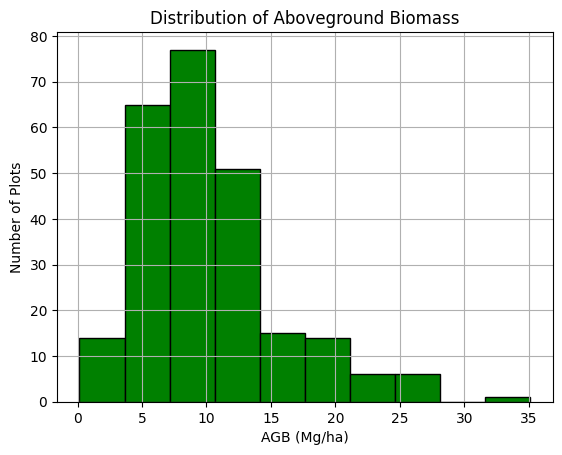

In [8]:
# Note that each plot has a radius of 14.1m (625m^2) 
# We need to convert to hectares, since this is the most common areal unit in forestry.
# There are 10000 m^2 in a hectare, so we divide by 10000.

plot_area_m2 = 625

plot_area_ha = plot_area_m2 / 10000

print(f"Area of each plot in hectares: {plot_area_ha} ha")

# Convert tree-level biomass from Kg/ha to Kg, and then to Mg (tonnes).
trees_df['biomass_kg'] = trees_df['biomass'] * plot_area_ha
trees_df['biomass_Mg'] = trees_df['biomass_kg'] / 1000  

biomass_df = (trees_df.groupby('PlotName').
                    agg(biomass_Mg_total=('biomass_Mg', 'sum')).
                    assign(biomass_Mg_ha=lambda x: x['biomass_Mg_total'] / plot_area_ha))

# Summarize biomass
print(biomass_df.describe())

# Join with plots GeoDataFrame
plots_gdf = plots_gdf.merge(biomass_df, on='PlotName', how='left')

ax = biomass_df['biomass_Mg_total'].hist(edgecolor='black', color='green')
ax.set_xlabel('AGB (Mg/ha)')
ax.set_ylabel('Number of Plots')
ax.set_title('Distribution of Aboveground Biomass')

### Basal Area


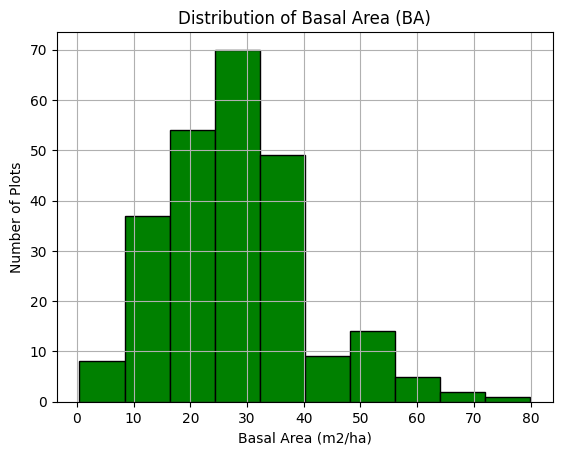

In [9]:
def get_ba(dbh):
    return ((dbh / 2) ** 2) * pi

ba_df = (trees_df
            .assign(ba_cm2=lambda x: get_ba(x['DBH']))
            .assign(ba_m2=lambda x: x['ba_cm2'] / 10000)
            .groupby('PlotName')
            .agg(total_ba_m2_ha=('ba_m2', 'sum'))
            .assign(ba_m2_ha=lambda x: x['total_ba_m2_ha'] / plot_area_ha)
            .reset_index())

ba_df.describe()

# Join with plots GeoDataFrame
plots_gdf = plots_gdf.merge(ba_df, on='PlotName', how='left')

ax = plots_gdf['ba_m2_ha'].hist(edgecolor='black', color='green')
ax.set_xlabel('Basal Area (m2/ha)')
ax.set_ylabel('Number of Plots')
ax.set_title('Distribution of Basal Area (BA)')
plt.show()

## Predictor Variables

### Airborne Laser Scanning (ALS) derived metrics.

We load the ALS metrics (ALS is a type of LiDAR) as an xarray dataset. xarray is similar to numpy arrays, but with added attributes and functionality. For example, xarrays can contain spatial coordinate reference systems (CRS).

In [10]:
# Read the 99th height percentile raster
als_metrics = rio.open_rasterio(r'data/als_metrics.tif')
als_metrics

<xarray.DataArray (band: 67, y: 366, x: 746)> Size: 73MB
[18293412 values with dtype=float32]
Coordinates:
  * band         (band) int64 536B 1 2 3 4 5 6 7 8 9 ... 60 61 62 63 64 65 66 67
  * x            (x) float64 6kB 2.974e+05 2.974e+05 ... 3.16e+05 3.16e+05
  * y            (y) float64 3kB 5.099e+06 5.099e+06 ... 5.09e+06 5.09e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.4028235e+38
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('avg_95', 'avg', 'b10', 'b20', 'b30', 'b40', 'b50', 'b60...

In [11]:
# Ensure that raster and plot coordinates are in the same CRS
assert plots_gdf.crs == als_metrics.rio.crs, "CRS mismatch between plots and raster data."

In [12]:
# Extract the ALS metric names for later use and convert to list from tuple
als_metrics_nms = list(als_metrics.long_name)

als_metrics_nms

['avg_95',
 'avg',
 'b10',
 'b20',
 'b30',
 'b40',
 'b50',
 'b60',
 'b70',
 'b80',
 'b90',
 'dns_10m',
 'dns_12m',
 'dns_14m',
 'dns_15m',
 'dns_16m',
 'dns_18m',
 'dns_20m',
 'dns_25m',
 'dns_2m',
 'dns_4m',
 'dns_5m',
 'dns_6m',
 'dns_8m',
 'kur_95',
 'p01',
 'p05',
 'p10',
 'p20',
 'p30',
 'p40',
 'p50',
 'p60',
 'p70',
 'p80',
 'p90',
 'p95',
 'p99',
 'qav',
 'skew_95',
 'd0_2',
 'd10_12',
 'd12_14',
 'd14_16',
 'd16_18',
 'd18_20',
 'd20_22',
 'd22_24',
 'd24_26',
 'd26_28',
 'd28_30',
 'd2_4',
 'd30_32',
 'd32_34',
 'd34_36',
 'd36_38',
 'd38_40',
 'd40_42',
 'd42_44',
 'd44_46',
 'd46_48',
 'd4_6',
 'd6_8',
 'd8_10',
 'std_95',
 'vci_1mbin',
 'vci_0.5bin']

In [13]:
# Get list of plot coordinates tuples
plot_coords = [(geom.x, geom.y) for geom in plots_gdf.geometry]

# Iterate through each ALS metric (by index) nd extract the value at the plot coordinates

for i, metric in enumerate(als_metrics_nms):

    print(f"Extracting metric: {metric}")

    metric_ras_i = als_metrics[i]

    plots_gdf[metric] = [float(metric_ras_i.sel(x=c[0], y=c[1], method="nearest").values) for c in plot_coords]

Extracting metric: avg_95
Extracting metric: avg
Extracting metric: b10
Extracting metric: b20
Extracting metric: b30
Extracting metric: b40
Extracting metric: b50
Extracting metric: b60
Extracting metric: b70
Extracting metric: b80
Extracting metric: b90
Extracting metric: dns_10m
Extracting metric: dns_12m
Extracting metric: dns_14m
Extracting metric: dns_15m
Extracting metric: dns_16m
Extracting metric: dns_18m
Extracting metric: dns_20m
Extracting metric: dns_25m
Extracting metric: dns_2m
Extracting metric: dns_4m
Extracting metric: dns_5m
Extracting metric: dns_6m
Extracting metric: dns_8m
Extracting metric: kur_95
Extracting metric: p01
Extracting metric: p05
Extracting metric: p10
Extracting metric: p20
Extracting metric: p30
Extracting metric: p40
Extracting metric: p50
Extracting metric: p60
Extracting metric: p70
Extracting metric: p80
Extracting metric: p90
Extracting metric: p95
Extracting metric: p99
Extracting metric: qav
Extracting metric: skew_95
Extracting metric: d0_2

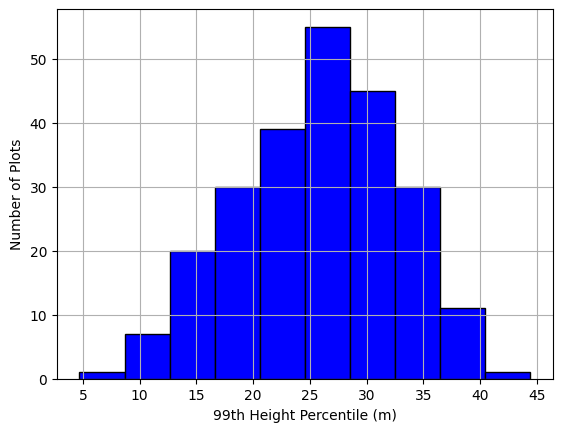

In [14]:
# View the distribution of the 99th percentile height
ax = plots_gdf['p99'].hist(edgecolor='black', color='blue')
ax.set_xlabel('99th Height Percentile (m)')
ax.set_ylabel('Number of Plots')
plt.show()

### Sentinel-2 Spectral Indices

While we can write code to calculate spectral indices, this can become time consuming once we start dealing with many different indices. Moreover, we can make mistakes in our code. As a suitable alternative, the `spyndex` Python package offers a standardized, simpler method for calculating many spectral indices at once.

Read the spyndex documentation here: [https://spyndex.readthedocs.io/en/stable/](https://spyndex.readthedocs.io/en/stable/)

In [15]:
# Load the Sentinel-2 imagery for 2018 (year the plots were sampled)
s2 = rio.open_rasterio(r'data/petawawa_s2_2018.tif')

assert plots_gdf.crs == s2.rio.crs, "CRS mismatch between plots and raster data."

# Consult the documentation for the spectral bands:
# https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED
s2


<xarray.DataArray (band: 12, y: 937, x: 1824)> Size: 82MB
[20509056 values with dtype=float32]
Coordinates:
  * band         (band) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * x            (x) float64 15kB 2.973e+05 2.973e+05 ... 3.155e+05 3.155e+05
  * y            (y) float64 7kB 5.099e+06 5.099e+06 ... 5.089e+06 5.089e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', '...

In [16]:
# Check range of reflectance for each band
print("Min reflectance in S2 data:", np.nanmin(s2.values))
print("Max reflectance in S2 data:", np.nanmax(s2.values))

Min reflectance in S2 data: 0.0013
Max reflectance in S2 data: 0.6144


**Consult this table for more details about band abbreviations used for spectral index calculation:**

[https://github.com/awesome-spectral-indices/awesome-spectral-indices?tab=readme-ov-file#expressions](https://github.com/awesome-spectral-indices/awesome-spectral-indices?tab=readme-ov-file#expressions)

In [17]:

print("Sentinel-2 band names order:", s2.long_name)

print("Spyndex band abbreviations:", spyndex.bands)


Sentinel-2 band names order: ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12')
Spyndex band abbreviations: ['A', 'B', 'G', 'G1', 'N', 'N2', 'R', 'RE1', 'RE2', 'RE3', 'S1', 'S2', 'T', 'T1', 'T2', 'WV', 'Y']


In [18]:
# Make a list of spectral indices to calculate
spec_index_ls = ["NDVI", "NBR", "SAVI", "MSAVI", "DSI", "NDWI", "GLI",  "ND705", "NDREI", "IRECI", "TGI"]

In [19]:
# One nice thing about spyndex is that it links each spectral index with a publication describing it.
# List all the publications for each index

for si in spec_index_ls:
    print(f"{si}: {indices[si].reference}")

NDVI: https://ntrs.nasa.gov/citations/19740022614
NBR: https://doi.org/10.3133/ofr0211
SAVI: https://doi.org/10.1016/0034-4257(88)90106-X
MSAVI: https://doi.org/10.1016/0034-4257(94)90134-1
DSI: https://www.asprs.org/wp-content/uploads/pers/1999journal/apr/1999_apr_495-501.pdf
NDWI: https://doi.org/10.1080/01431169608948714
GLI: http://dx.doi.org/10.1080/10106040108542184
ND705: https://doi.org/10.1016/S0034-4257(02)00010-X
NDREI: https://doi.org/10.1016/1011-1344(93)06963-4
IRECI: https://doi.org/10.1016/j.isprsjprs.2013.04.007
TGI: http://dx.doi.org/10.1016/j.jag.2012.07.020


In [20]:
# Compute all the spectral indices

spec_indeces = spyndex.computeIndex(
    index = spec_index_ls,
    params = {
        "A": s2[0], 
        "B": s2[1],
        "G": s2[2],
        "R": s2[3],
        "RE1": s2[4],
        "RE2": s2[5],
        "RE3": s2[6],
        "N": s2[7],
        "N2": s2[8],
        "WV": s2[9],
        "S1": s2[10],
        "S2": s2[11],
        "L": 1
    }

)

In [21]:
# Extract spectral indices at the plot coordinates

for si_name in spec_index_ls:

    print(f"Extracting {si_name} values at plot coordinates...")

    si_raster = spec_indeces[spec_indeces.index == si_name]

    plots_gdf[si_name] = [si_raster.sel(x=c[0], y=c[1], method="nearest").values[0] for c in plot_coords]

plots_gdf.head(5)


Extracting NDVI values at plot coordinates...
Extracting NBR values at plot coordinates...
Extracting SAVI values at plot coordinates...
Extracting MSAVI values at plot coordinates...
Extracting DSI values at plot coordinates...
Extracting NDWI values at plot coordinates...
Extracting GLI values at plot coordinates...
Extracting ND705 values at plot coordinates...
Extracting NDREI values at plot coordinates...
Extracting IRECI values at plot coordinates...
Extracting TGI values at plot coordinates...


,PlotName,Date,Northing,Easting,Source,geometry,qmd,biomass_Mg_total,biomass_Mg_ha,total_ba_m2_ha,...,NBR,SAVI,MSAVI,DSI,NDWI,GLI,ND705,NDREI,IRECI,TGI
0,PRF208R,August 7 2018,5098426.096,312924.933,Topcon Hiper V PPP,POINT Z (312924.734 5098427.112 0),9.785100,0.876200,14.019203,0.248161,...,0.709994,0.488931,0.606115,0.387605,-0.750999,0.364300,0.547740,0.637373,1.063289,2.5840
1,PRF320,November 23 2018,5098579.361,312625.094,Topcon HiperSR PPP,POINT Z (312624.895 5098580.377 0),18.259018,8.952006,143.232099,1.492518,...,0.540868,0.356151,0.419385,0.590963,-0.709425,0.278922,0.500269,0.565841,0.659723,1.7700
2,PRF016,August 8 2018,5096992.483,313662.119,Topcon Hiper V PPP,POINT Z (313661.921 5096993.499 0),16.213670,6.809870,108.957923,1.465922,...,0.678063,0.422625,0.517317,0.407470,-0.762945,0.349233,0.577111,0.658688,0.940175,1.9025
3,PRF017,August 14 2018,5096896.098,313863.850,Topcon Hiper V PPP,POINT Z (313863.652 5096897.114 0),16.701949,4.659434,74.550945,0.942091,...,0.580265,0.323558,0.377138,0.545701,-0.709203,0.276740,0.502744,0.579135,0.585677,1.5210
4,PRF018,August 8 2018,5097138.299,313692.563,Topcon Hiper V PPP,POINT Z (313692.365 5097139.315 0),15.854214,6.700145,107.202327,1.263454,...,0.514979,0.296583,0.338885,0.609699,-0.652275,0.250350,0.446976,0.541924,0.420730,1.7405


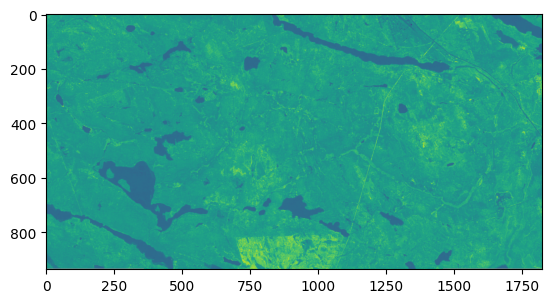

<Axes: >

In [22]:
# View one of the spectral indices

view_si_nm = "NDVI"

view_si_raster = spec_indeces[spec_indeces.index == si_name]

show(view_si_raster.values[0], cmap='viridis')

In [36]:
# Convert geodataframe to regular dataframe for easier manipulation
plots_df = pd.DataFrame(plots_gdf)
plots_df

,PlotName,Date,Northing,Easting,Source,geometry,qmd,biomass_Mg_total,biomass_Mg_ha,total_ba_m2_ha,...,NBR,SAVI,MSAVI,DSI,NDWI,GLI,ND705,NDREI,IRECI,TGI
0,PRF208R,August 7 2018,5098426.096,312924.933,Topcon Hiper V PPP,POINT Z (312924.734 5098427.112 0),9.785100,0.876200,14.019203,0.248161,...,0.709994,0.488931,0.606115,0.387605,-0.750999,0.364300,0.547740,0.637373,1.063289,2.58400
1,PRF320,November 23 2018,5098579.361,312625.094,Topcon HiperSR PPP,POINT Z (312624.895 5098580.377 0),18.259018,8.952006,143.232099,1.492518,...,0.540868,0.356151,0.419385,0.590963,-0.709425,0.278922,0.500269,0.565841,0.659723,1.77000
2,PRF016,August 8 2018,5096992.483,313662.119,Topcon Hiper V PPP,POINT Z (313661.921 5096993.499 0),16.213670,6.809870,108.957923,1.465922,...,0.678063,0.422625,0.517317,0.407470,-0.762945,0.349233,0.577111,0.658688,0.940175,1.90250
3,PRF017,August 14 2018,5096896.098,313863.850,Topcon Hiper V PPP,POINT Z (313863.652 5096897.114 0),16.701949,4.659434,74.550945,0.942091,...,0.580265,0.323558,0.377138,0.545701,-0.709203,0.276740,0.502744,0.579135,0.585677,1.52100
4,PRF018,August 8 2018,5097138.299,313692.563,Topcon Hiper V PPP,POINT Z (313692.365 5097139.315 0),15.854214,6.700145,107.202327,1.263454,...,0.514979,0.296583,0.338885,0.609699,-0.652275,0.250350,0.446976,0.541924,0.420730,1.74050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,PRF183,November 4 2018,5091453.546,301823.319,Topcon Hiper V PPP,POINT Z (301823.119 5091454.56 0),39.737927,25.045543,400.728695,3.472629,...,0.644644,0.370974,0.442169,0.468799,-0.734483,0.299131,0.530469,0.594032,0.765510,1.68025
244,PRF187,November 22 2018,5091476.078,308950.650,Topcon Hiper V PPP,POINT Z (308950.451 5091477.093 0),31.497227,18.988047,303.808749,2.337522,...,0.734751,0.587168,0.751833,0.358186,-0.813827,0.393871,0.614451,0.733076,1.504955,2.42300
245,PRF209,October 19 2018,5091851.419,312997.322,Topcon Hiper V PPP,POINT Z (312997.124 5091852.434 0),17.232562,9.289533,148.632535,2.145742,...,0.647397,0.315994,0.367099,0.462700,-0.693428,0.276003,0.527052,0.583441,0.633813,1.54825
246,PRF214,October 6 2018,5091627.257,312973.063,Topcon Hiper V PPP,POINT Z (312972.865 5091628.272 0),25.591809,8.882557,142.120910,1.491729,...,0.559464,0.348880,0.410888,0.578022,-0.712261,0.303371,0.495551,0.532509,0.689743,1.78550


In [37]:
# Make lists of all predictor and response variables
predictor_vars = spec_index_ls + als_metrics_nms
print("Predictor variables:", predictor_vars)

response_vars = ["biomass_Mg_ha", "ba_m2_ha", "qmd"]
print("Response variables:", response_vars)

Predictor variables: ['NDVI', 'NBR', 'SAVI', 'MSAVI', 'DSI', 'NDWI', 'GLI', 'ND705', 'NDREI', 'IRECI', 'TGI', 'avg_95', 'avg', 'b10', 'b20', 'b30', 'b40', 'b50', 'b60', 'b70', 'b80', 'b90', 'dns_10m', 'dns_12m', 'dns_14m', 'dns_15m', 'dns_16m', 'dns_18m', 'dns_20m', 'dns_25m', 'dns_2m', 'dns_4m', 'dns_5m', 'dns_6m', 'dns_8m', 'kur_95', 'p01', 'p05', 'p10', 'p20', 'p30', 'p40', 'p50', 'p60', 'p70', 'p80', 'p90', 'p95', 'p99', 'qav', 'skew_95', 'd0_2', 'd10_12', 'd12_14', 'd14_16', 'd16_18', 'd18_20', 'd20_22', 'd22_24', 'd24_26', 'd26_28', 'd28_30', 'd2_4', 'd30_32', 'd32_34', 'd34_36', 'd36_38', 'd38_40', 'd40_42', 'd42_44', 'd44_46', 'd46_48', 'd4_6', 'd6_8', 'd8_10', 'std_95', 'vci_1mbin', 'vci_0.5bin']
Response variables: ['biomass_Mg_ha', 'ba_m2_ha', 'qmd']


In [38]:
# Remove any nan values present in the predictor or response variables
plots_df = plots_df.dropna(subset=response_vars + predictor_vars)
plots_df.shape

(239, 89)

In [39]:
# View correlation matrix of the response and predictor variables
corr_matrix = plots_df[response_vars + predictor_vars].corr()
corr_matrix

,biomass_Mg_ha,ba_m2_ha,qmd,NDVI,NBR,SAVI,MSAVI,DSI,NDWI,GLI,...,d40_42,d42_44,d44_46,d46_48,d4_6,d6_8,d8_10,std_95,vci_1mbin,vci_0.5bin
biomass_Mg_ha,1.000000,0.914255,0.535914,0.093842,0.200617,0.074345,0.067442,-0.206647,-0.132355,-0.026347,...,0.180204,0.175293,0.175293,0.175293,-0.357623,-0.326550,-0.304588,0.373794,0.197033,0.204754
ba_m2_ha,0.914255,1.000000,0.389644,0.038703,0.239056,-0.080360,-0.083297,-0.264476,-0.068731,-0.131092,...,0.144544,0.141415,0.141415,0.141415,-0.324034,-0.205984,-0.140529,0.235472,0.275512,0.280126
qmd,0.535914,0.389644,1.000000,-0.150855,-0.180031,-0.000869,-0.016822,0.190720,0.078660,-0.144257,...,0.158974,0.153131,0.153131,0.153131,-0.384423,-0.410504,-0.398955,0.582865,-0.256560,-0.246888
NDVI,0.093842,0.038703,-0.150855,1.000000,0.856760,0.836805,0.846581,-0.805253,-0.895448,0.835415,...,-0.009927,-0.006702,-0.006702,-0.006702,-0.049338,0.076836,0.121188,-0.386174,0.334287,0.390578
NBR,0.200617,0.239056,-0.180031,0.856760,1.000000,0.685963,0.693453,-0.982826,-0.809509,0.630777,...,-0.015109,-0.013062,-0.013062,-0.013062,-0.039172,0.163813,0.230483,-0.370044,0.377606,0.423200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d6_8,-0.326550,-0.205984,-0.410504,0.076836,0.163813,-0.028344,-0.025835,-0.179205,-0.016325,0.077263,...,-0.022038,-0.019802,-0.019802,-0.019802,0.680582,1.000000,0.695121,-0.413712,0.139755,0.144337
d8_10,-0.304588,-0.140529,-0.398955,0.121188,0.230483,0.012181,0.014714,-0.247571,-0.055454,0.102985,...,-0.026527,-0.024305,-0.024305,-0.024305,0.287278,0.695121,1.000000,-0.460669,0.166322,0.177571
std_95,0.373794,0.235472,0.582865,-0.386174,-0.370044,-0.323882,-0.330801,0.356168,0.235313,-0.456881,...,0.172659,0.165714,0.165714,0.165714,-0.235786,-0.413712,-0.460669,1.000000,-0.067088,-0.095639
vci_1mbin,0.197033,0.275512,-0.256560,0.334287,0.377606,0.028549,0.041252,-0.390876,-0.259506,0.114473,...,0.073803,0.074019,0.074019,0.074019,0.180887,0.139755,0.166322,-0.067088,1.000000,0.992041


<Axes: xlabel='p99', ylabel='biomass_Mg_ha'>

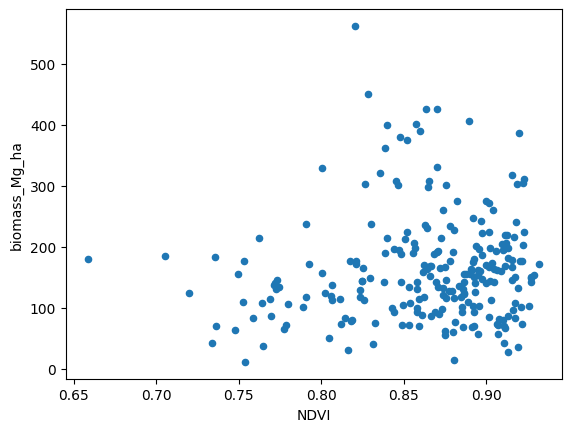

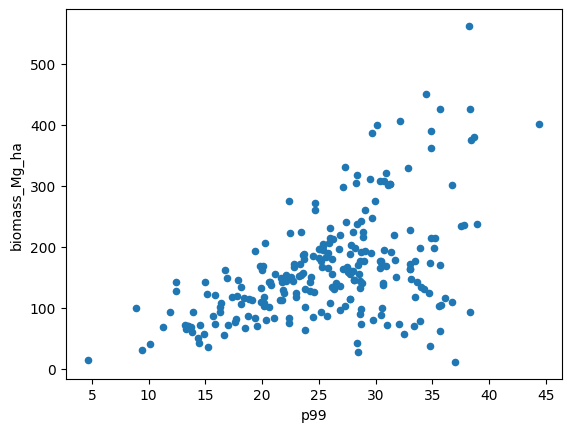

In [ ]:
# Plot some of the data
plots_df.plot.scatter(x='NDVI', y='biomass_Mg_ha')
plots_df.plot.scatter(x='p99', y='biomass_Mg_ha')

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Set target variable

target_var = "biomass_Mg_ha"

# Divide features and targets into separate DataFrames
X = plots_gdf[predictor_vars]
# X = plots_df[['p99', 'NDVI']]
y = plots_gdf[target_var]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a lasso regression model with initial alpha=0.1
lasso = Lasso(alpha=0.99, max_iter=100000)
lasso.fit(X_train, y_train)

Lasso(alpha=0.99, max_iter=100000)

In [76]:
y_test_pred = lasso.predict(X_test)

# Calculate R2 and RMSE
r2 = r2_score(y_test, y_test_pred)
rmse = sqrt(mean_squared_error(y_test, y_test_pred))
print(f"R2: {r2:.3f}, RMSE: {rmse:.3f}")

R2: 0.656, RMSE: 49.862


In [77]:
# View the parameters of the model
print("Lasso coefficients:")
for feature, coef in zip(X.columns, lasso.coef_):
    print(f"{feature}: {coef:.4f}")

Lasso coefficients:
NDVI: -0.0000
NBR: 0.0000
SAVI: -0.0000
MSAVI: -0.0000
DSI: -0.0000
NDWI: 0.0000
GLI: -0.0000
ND705: 0.0000
NDREI: -0.0000
IRECI: -31.4118
TGI: -0.0000
avg_95: -0.0000
avg: -0.0000
b10: 0.6092
b20: 0.0000
b30: -0.6441
b40: 1.5178
b50: -2.7004
b60: 2.3315
b70: 1.2943
b80: -2.8181
b90: 2.3629
dns_10m: 0.0000
dns_12m: 0.0691
dns_14m: 0.0000
dns_15m: -0.0000
dns_16m: -0.0000
dns_18m: 0.4080
dns_20m: -0.0000
dns_25m: -0.0000
dns_2m: 0.0000
dns_4m: 0.0000
dns_5m: 0.7576
dns_6m: 0.0000
dns_8m: 0.0000
kur_95: -0.0000
p01: -4.6062
p05: -2.3500
p10: 2.1019
p20: -3.1069
p30: 1.8169
p40: -3.7183
p50: 3.4267
p60: -1.2023
p70: -2.0014
p80: -2.0688
p90: 0.0000
p95: -2.0599
p99: 0.0000
qav: 0.5494
skew_95: -0.0525
d0_2: -0.0000
d10_12: 0.0000
d12_14: 0.0000
d14_16: 3.0425
d16_18: -0.8155
d18_20: 2.7129
d20_22: 0.2780
d22_24: -0.0000
d24_26: -0.0000
d26_28: 2.4272
d28_30: -0.0000
d2_4: 0.0000
d30_32: -5.2210
d32_34: 13.7705
d34_36: -5.3679
d36_38: 0.6547
d38_40: 0.0000
d40_42: -0.00

# Export preprocessed data for additional modelling

In [ ]:
plots_gdf